In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pgmpy
!pip install tqdm
!pip install networkx matplotlib

In [ ]:
import sys
import os

project_path = '/content/drive/My Drive/ICON'
src_path = os.path.join(project_path, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)
try:
    os.chdir(project_path)
except FileNotFoundError:
    print(f"cartella non trovata")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from loader_dati import carica_e_pulisci_base, riempimento_dati
from eda import esegui_eda_base, traccia_distribuzioni
from preprocessing import preprocessa_dati
from clustering import trova_k_ottimale, applica_kmeans_e_aggiungi_feature
from modelli import ottieni_modelli, ottieni_griglie_parametri
from valutazioni import ottimizza_e_valuta_modelli_cv, stampa_risultati_cv
from rete_bayesiana import valuta_rete_bayesiana

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
PERCORSO_FILE_CSV = 'dataset/heart-disease/heart_disease_uci.csv'
COLONNA_TARGET = 'target'
NUM_SPLIT_ESTERNI = 10
NUM_SPLIT_INTERNI = 5
MAX_K_CLUSTERING = 8
STATO_CASUALE = 42
K_OTTIMALE = 4 #da verificare

In [ ]:

df_dati_con_nan = carica_e_pulisci_base(PERCORSO_FILE_CSV)
df_dati_riempiti = riempimento_dati(df_dati_con_nan.copy() if df_dati_con_nan is not None else None)
if df_dati_riempiti is not None:
    print("\nload ok")
    print("\ndati nan:")
    print(df_dati_con_nan.head())
    print("\ndati riempiti:")
    print(df_dati_riempiti.head())
    print(f"\nnan nei riempiti: {df_dati_riempiti.isnull().sum().sum()}")
else:
    print("loead e pulizia falliti.")

load e pulizia
dataset caricato
pulizia ok
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    Int64  
 6   restecg   920 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    Int64  
 9   oldpeak   858 non-null    float64
 10  slope     920 non-null    object 
 11  ca        309 non-null    Int64  
 12  thal      920 non-null    object 
 13  target    920 non-null    int64  
dtypes: Int64(3), float64(4), int64(3), object(4)
memory usage: 103.4+ KB

valori mancanti: 962
nan restanti: 0

load ok

dati nan:
   age  sex               cp  trestbps   chol  fbs         restecg  thalch  \
0   63    1   typi

dati inziali:
   age  sex               cp  trestbps   chol  fbs         restecg  thalch  \
0   63    1   typical angina     145.0  233.0    1  lv hypertrophy   150.0   
1   67    1     asymptomatic     160.0  286.0    0  lv hypertrophy   108.0   
2   67    1     asymptomatic     120.0  229.0    0  lv hypertrophy   129.0   
3   37    1      non-anginal     130.0  250.0    0          normal   187.0   
4   41    0  atypical angina     130.0  204.0    0  lv hypertrophy   172.0   

   exang  oldpeak        slope  ca               thal  target  
0      0      2.3  downsloping   0       fixed defect       0  
1      1      1.5         flat   3             normal       1  
2      1      2.6         flat   2  reversable defect       1  
3      0      3.5  downsloping   0             normal       0  
4      0      1.4    upsloping   0             normal       0  

info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column  

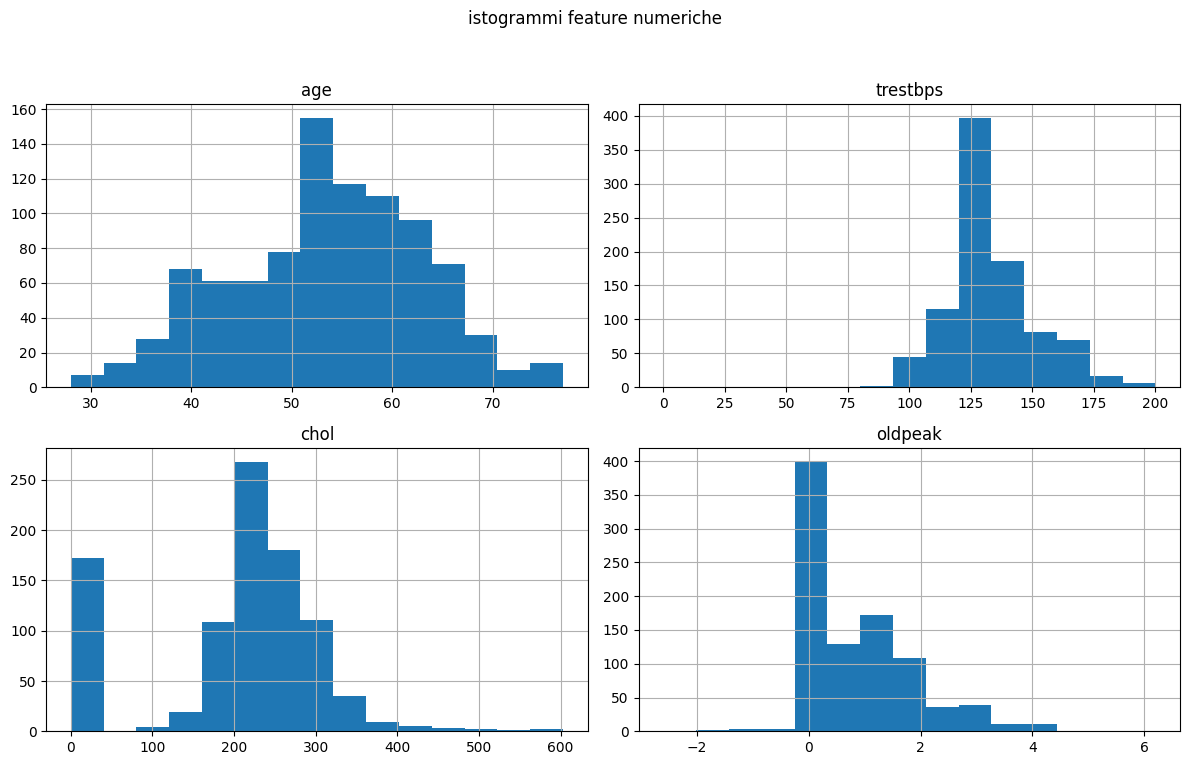

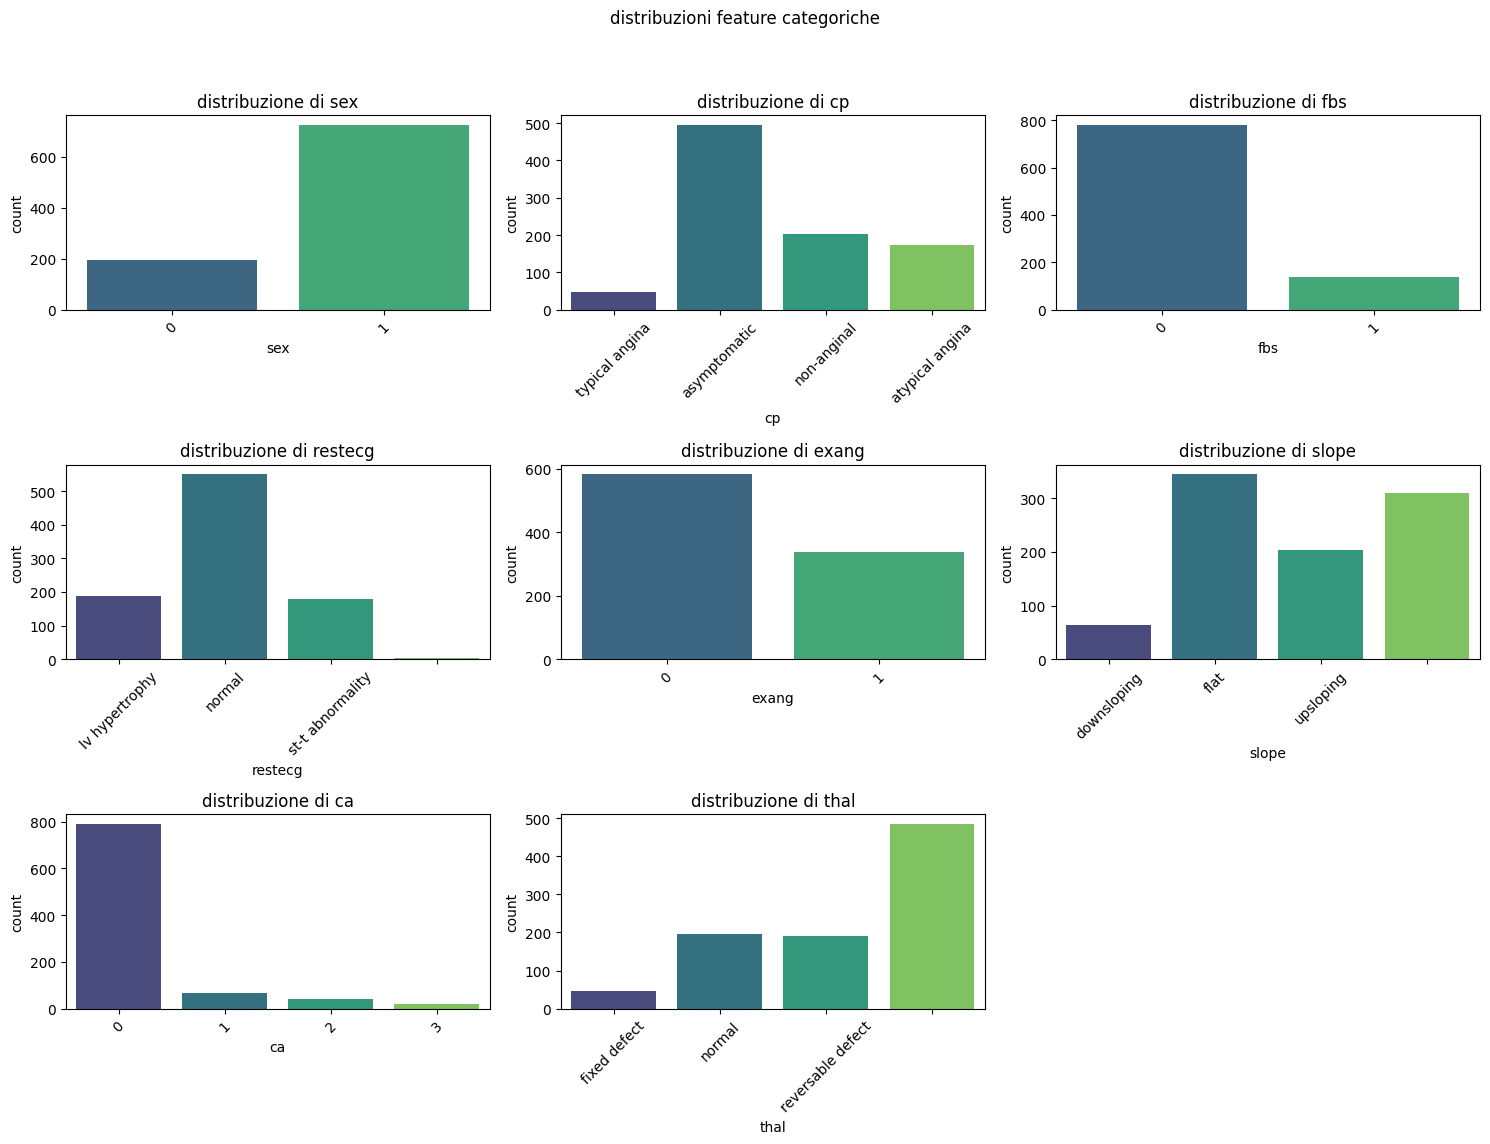

In [ ]:
if df_dati_riempiti is not None:
    esegui_eda_base(df_dati_riempiti)
    traccia_distribuzioni(df_dati_riempiti)
else:
    print("load fallito")

In [ ]:
 #preprocessing Iniziale (no cluster)
X_proc_no_cluster, y_target, preprocessore_no_cluster, nomi_feature_no_cluster = None, None, None, None
if df_dati_riempiti is not None:
    X_proc_no_cluster, y_target, preprocessore_no_cluster, nomi_feature_no_cluster = preprocessa_dati(df_dati_riempiti.copy(), COLONNA_TARGET)
else:
    print("errore caricamento, preprocessing saltato")


if X_proc_no_cluster is not None:
    try:
        print("\nprime righe dati processati (senza cluster):")
        print(pd.DataFrame(X_proc_no_cluster, columns=nomi_feature_no_cluster).head())
    except ValueError:
         print("impossibile mostrare dataframe preprocessato.")


prime righe dati processati (senza cluster):
        age  trestbps      chol    thalch   oldpeak cp_asymptomatic  \
0  1.007386  0.705176  0.303643  0.489727  1.368109             0.0   
1  1.432034  1.518569  0.789967 -1.181478  0.611589             1.0   
2  1.432034 -0.650479  0.266939 -0.345875  1.651804             1.0   
3 -1.752828 -0.108217  0.459634  1.961979  2.502889             0.0   
4  -1.32818 -0.108217  0.037541   1.36512  0.517024             0.0   

  cp_atypical angina cp_non-anginal cp_typical angina restecg_  ... ca_1.0  \
0                0.0            0.0               1.0      0.0  ...    0.0   
1                0.0            0.0               0.0      0.0  ...    0.0   
2                0.0            0.0               0.0      0.0  ...    0.0   
3                0.0            1.0               0.0      0.0  ...    0.0   
4                1.0            0.0               0.0      0.0  ...    0.0   

  ca_2.0 ca_3.0 thal_ thal_fixed defect thal_normal thal_r


ricerca del k Ottimale


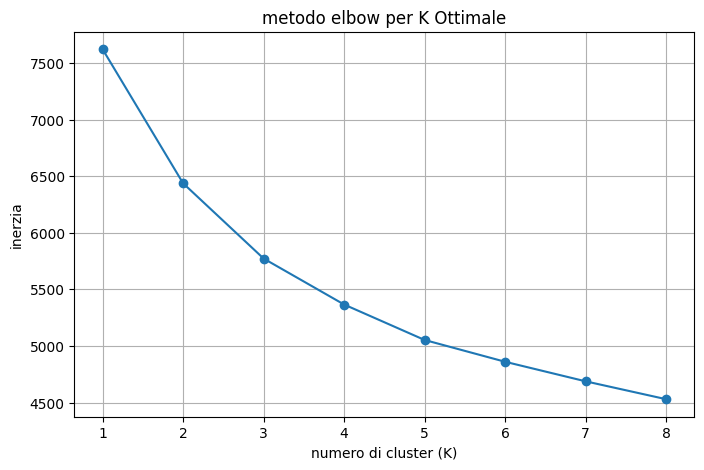

In [ ]:
# Per trovare il K ottimale
if X_proc_no_cluster is not None:
    trova_k_ottimale(X_proc_no_cluster, max_k=MAX_K_CLUSTERING, stato_casuale=STATO_CASUALE)
else:
    print("clustering saltato errore preprocessing.")

In [ ]:
# applicazione k-means e feature con cluster
X_proc_con_cluster, preprocessore_con_cluster, nomi_feature_con_cluster = None, None, None
if X_proc_no_cluster is not None and df_dati_riempiti is not None:
    X_proc_con_cluster, preprocessore_con_cluster, nomi_feature_con_cluster, etichette_cluster = applica_kmeans_e_aggiungi_feature(
    df_dati_riempiti.drop(COLONNA_TARGET, axis=1),
    X_proc_no_cluster,
    K_OTTIMALE,
    stato_casuale=STATO_CASUALE
)
if df_dati_riempiti is not None and etichette_cluster is not None:
     df_dati_con_cluster = df_dati_riempiti.copy()
     df_dati_con_cluster['cluster'] = etichette_cluster
     print("\nDataFrame originale con etichette cluster aggiunto:")
     print(df_dati_con_cluster[['target', 'cluster']].head())
else:
    print("feature cluster saltata.")

if X_proc_con_cluster is not None:
    try:
        print("\nrighe dati processati (cluster):")
        print(pd.DataFrame(X_proc_con_cluster, columns=nomi_feature_con_cluster).head())
    except ValueError:
        print("impossibile mostrare dataframe con cluster")


applicazione k-means, k=4
aggiunta feature 'cluster' (K=4)

DataFrame originale con etichette cluster aggiunto:
   target  cluster
0       0        1
1       1        1
2       1        1
3       0        0
4       0        0

righe dati processati (cluster):
        age  trestbps      chol    thalch   oldpeak cp_asymptomatic  \
0  1.007386  0.705176  0.303643  0.489727  1.368109             0.0   
1  1.432034  1.518569  0.789967 -1.181478  0.611589             1.0   
2  1.432034 -0.650479  0.266939 -0.345875  1.651804             1.0   
3 -1.752828 -0.108217  0.459634  1.961979  2.502889             0.0   
4  -1.32818 -0.108217  0.037541   1.36512  0.517024             0.0   

  cp_atypical angina cp_non-anginal cp_typical angina restecg_  ...  \
0                0.0            0.0               1.0      0.0  ...   
1                0.0            0.0               0.0      0.0  ...   
2                0.0            0.0               0.0      0.0  ...   
3                0.0        

In [ ]:
#analisi cluster
if 'df_dati_con_cluster' in locals() and df_dati_con_cluster is not None:
    colonne_numeriche_originali = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
    colonne_categoriche_originali = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

    print("\nmedie feature numeriche per cluster:")
    medie_cluster = df_dati_con_cluster.groupby('cluster')[colonne_numeriche_originali].mean()
    print(medie_cluster)
    print("\nmoda feature categoriche cluster:")
    for col in colonne_categoriche_originali:
        if col in df_dati_con_cluster.columns:
             print(f"\ndistribuzione '{col}' per cluster:")
             freq_rel = df_dati_con_cluster.groupby('cluster')[col].value_counts(normalize=True).unstack(fill_value=0) * 100
             print(freq_rel.round(1).to_string())

    print("\ndistribuzione target per cluster")
    print((df_dati_con_cluster.groupby('cluster')['target'].value_counts(normalize=True).unstack(fill_value=0) * 100).round(1))

else:
    print("dataframe non disponibile per l'analisi.")


medie feature numeriche per cluster:
               age    trestbps        chol      thalch   oldpeak
cluster                                                         
0        51.961353  128.483092  247.816425  161.260870  0.526570
1        57.377432  138.926070  252.649805  124.498054  1.907393
2        49.405694  129.893238  239.170819  141.644128  0.159075
3        56.257143  129.348571    2.742857  122.845714  0.806286

moda feature categoriche cluster:

distribuzione 'sex' per cluster:
sex         0     1
cluster            
0        35.7  64.3
1        16.3  83.7
2        23.5  76.5
3         6.9  93.1

distribuzione 'cp' per cluster:
cp       asymptomatic  atypical angina  non-anginal  typical angina
cluster                                                            
0                31.4             23.7         37.2             7.7
1                83.3              4.3          7.8             4.7
2                31.3             38.1         26.0             4.6
3         

In [ ]:
#modelli e grid
tutti_i_modelli = ottieni_modelli(stato_casuale=STATO_CASUALE)
griglie_parametri = ottieni_griglie_parametri()

modelli_standard = tutti_i_modelli
griglie_standard = griglie_parametri

print("Modelli e griglie definiti (senza Naive Bayes).")
print("Modelli Standard:", list(modelli_standard.keys()))
print("Griglie Standard:", griglie_standard)

Modelli e griglie definiti (senza Naive Bayes).
Modelli Standard: ['Regressione Logistica', 'Albero Decisionale', 'SVM']
Griglie Standard: {'Regressione Logistica': {'C': [0.01, 0.1, 1, 10, 100]}, 'Albero Decisionale': {'max_depth': [None, 5, 10, 15], 'min_samples_leaf': [1, 5, 10]}, 'SVM': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1]}}


valutazione rete bayesiana

valutazione rete con 3-fold 
binning feature numeriche
binning ok

fold 1/3
  struttura
  struttura ok: 16 archi
  parametri
  predizione


Fold 1: 100%|██████████| 307/307 [00:00<00:00, 462.34it/s]


 predizione ok: 305/307 istanze processate
  fold 1 ok:
    Accuracy: 0.8013, AUC: 0.8653
    Precision: 0.8011, Recall: 0.8529, F1: 0.8262

fold 2/3
  struttura
  struttura ok: 14 archi
  parametri
  predizione


Fold 2: 100%|██████████| 307/307 [00:00<00:00, 1176.99it/s]


 predizione ok: 307/307 istanze processate
  fold 2 ok:
    Accuracy: 0.7752, AUC: 0.8685
    Precision: 0.7886, Recall: 0.8118, F1: 0.8000

fold 3/3
  struttura
  struttura ok: 13 archi
  parametri
  predizione


Fold 3: 100%|██████████| 306/306 [00:00<00:00, 1185.56it/s]


 predizione ok: 306/306 istanze processate
  fold 3 ok:
    Accuracy: 0.7974, AUC: 0.8524
    Precision: 0.8092, Recall: 0.8284, F1: 0.8187
risultati rete bayesiana
  accuracy  : 0.7913 (+/- 0.0115)
  precision : 0.7996 (+/- 0.0085)
  recall    : 0.8310 (+/- 0.0169)
  f1        : 0.8150 (+/- 0.0110)
  roc_auc   : 0.8621 (+/- 0.0070)

struttura migliore fold 2 (AUC: 0.8685)


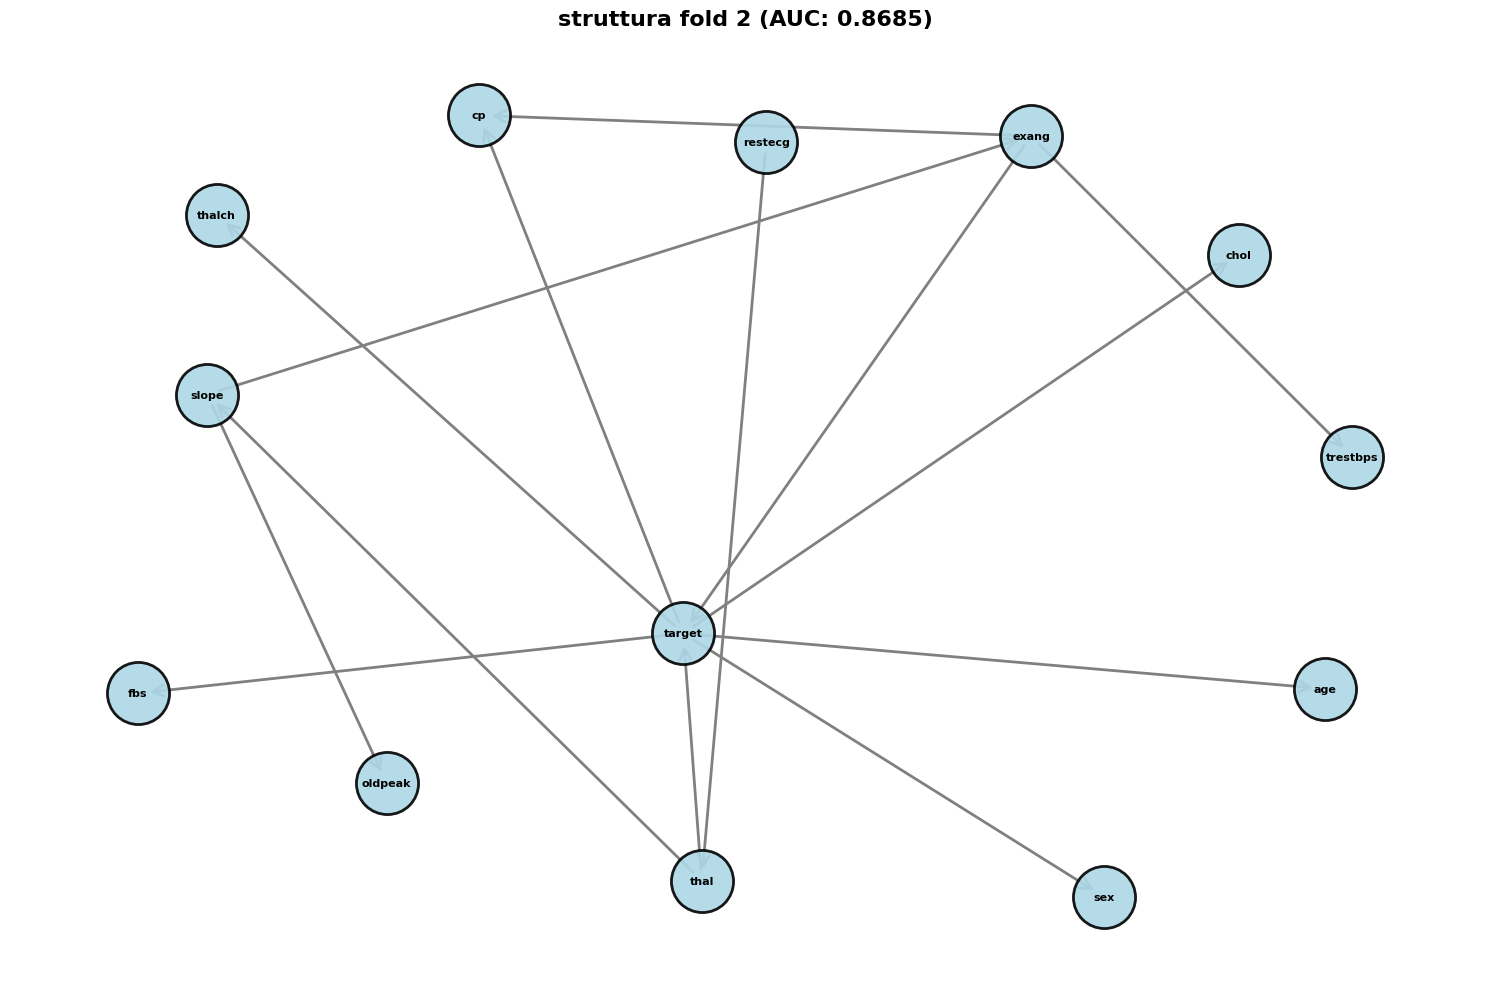

salvato in: rete_bayesiana_fold_2_auc_0.8685.png


In [ ]:
#valutazione rete bayesiana
risultati_bn_dict = None
if 'df_dati_riempiti' in locals() and df_dati_riempiti is not None:
    try:
        print("valutazione rete bayesiana")
        risultati_bn_dict, _ = valuta_rete_bayesiana(
            df_dati_riempiti.copy(),
            target_col=COLONNA_TARGET,
            num_split=3,  # Usa 3 fold per velocità
            stato_casuale=STATO_CASUALE,
            plot_miglior_struttura=True
        )
    except Exception as e:
        print(f"errore: {e}")
        metriche = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        risultati_bn_dict = {
            'rete bayesiana': {
                'scores': {f'test_{m}': np.array([np.nan] * 3) for m in metriche}
            }
        }
else:
    print("valutazione saltata")

In [ ]:
#valutazione modelli normali senza cluster
print("valutazione modelli normali senza cluster")
risultati_no_cluster = None
if X_proc_no_cluster is not None and y_target is not None:
    risultati_no_cluster = ottimizza_e_valuta_modelli_cv(
        modelli_standard, griglie_standard, X_proc_no_cluster, y_target,
        num_split_esterni=NUM_SPLIT_ESTERNI, num_split_interni=NUM_SPLIT_INTERNI, stato_casuale=STATO_CASUALE
    )
else:
    print("valutazione modelli normali senza cluster")

valutazione modelli normali senza cluster
tuning-valutazione split esterni=10, interni=5)
tuning-valutazione Regressione Logistica...
tuning-valutazione Regressione Logistica ok.
tuning-valutazione Albero Decisionale...
tuning-valutazione Albero Decisionale ok.
tuning-valutazione SVM...
tuning-valutazione SVM ok.


In [ ]:
#valutazione modelli normali con cluster
print("valutazione modelli normali con cluster")
risultati_con_cluster = None
if X_proc_con_cluster is not None and y_target is not None:

    modelli_standard_clust = ottieni_modelli(stato_casuale=STATO_CASUALE)
    modelli_standard_clust = {nome: modello for nome, modello in modelli_standard_clust.items() if nome != 'Naive Bayes'}

    risultati_con_cluster = ottimizza_e_valuta_modelli_cv(
        modelli_standard_clust, griglie_standard, X_proc_con_cluster, y_target,
        num_split_esterni=NUM_SPLIT_ESTERNI, num_split_interni=NUM_SPLIT_INTERNI, stato_casuale=STATO_CASUALE
    )
else:
    print("valutazione modelli normali con cluster saltata")

valutazione modelli normali con cluster
tuning-valutazione split esterni=10, interni=5)
tuning-valutazione Regressione Logistica...
tuning-valutazione Regressione Logistica ok.
tuning-valutazione Albero Decisionale...
tuning-valutazione Albero Decisionale ok.
tuning-valutazione SVM...
tuning-valutazione SVM ok.


In [ ]:
#riepilogo risultati
print("riepilogo risultati")
risultati_finali_combinati = {}

def aggiungi_parametri_mancanti(risultati_dict):
    for nome, dati in risultati_dict.items():
        if dati and 'best_params_per_fold' not in dati:
            if 'scores' in dati and dati['scores']:
                first_metric_key = next(iter(dati['scores'].keys()))
                num_folds = len(dati['scores'][first_metric_key])
                dati['best_params_per_fold'] = ["N/A"] * num_folds
    return risultati_dict

if 'risultati_bn_dict' in locals() and risultati_bn_dict:
    risultati_bn_dict_corretto = aggiungi_parametri_mancanti(risultati_bn_dict)
    risultati_finali_combinati.update(risultati_bn_dict_corretto)

if 'risultati_no_cluster' in locals() and risultati_no_cluster:
    risultati_no_cluster_corretto = aggiungi_parametri_mancanti(risultati_no_cluster)
    risultati_finali_combinati.update(risultati_no_cluster_corretto)

if 'risultati_con_cluster' in locals() and risultati_con_cluster:
    risultati_con_cluster_corretto = aggiungi_parametri_mancanti(risultati_con_cluster)
    for nome_modello, dati_ris in risultati_con_cluster_corretto.items():
        nome_nuovo = nome_modello.replace(" (tuned)", " + clust (tuned)") if " (tuned)" in nome_modello else nome_modello + " + clust"
        risultati_finali_combinati[nome_nuovo] = dati_ris

if risultati_finali_combinati:
    print(f"modelli: {list(risultati_finali_combinati.keys())}")
    df_risultati_finali = stampa_risultati_cv(risultati_finali_combinati)

    try:
        df_risultati_finali.to_csv('risultati_finali_comparazione_modelli.csv')
        print("\nrisultati salvati")
    except Exception as e:
        print(f"\nrisultati non salvati: {e}")
else:
    print("nessun riepilogo")

riepilogo risultati
modelli: ['rete bayesiana', 'Regressione Logistica (Tuned)', 'Albero Decisionale (Tuned)', 'SVM (Tuned)', 'Regressione Logistica (Tuned) + clust', 'Albero Decisionale (Tuned) + clust', 'SVM (Tuned) + clust']

risultati CV e parametri

modello: rete bayesiana
  accuracy: 0.7913 (+/- 0.0115)
  precision: 0.7996 (+/- 0.0085)
  recall: 0.8310 (+/- 0.0169)
  f1: 0.8150 (+/- 0.0110)
  roc_auc: 0.8621 (+/- 0.0070)
param ottimiali: Struttura: 16 archi

modello: Regressione Logistica (Tuned)
  accuracy: 0.8293 (+/- 0.0415)
  precision: 0.8376 (+/- 0.0324)
  recall: 0.8585 (+/- 0.0631)
  f1: 0.8469 (+/- 0.0398)
  roc_auc: 0.8898 (+/- 0.0304)
param ottimiali: {'C': 0.1}

modello: Albero Decisionale (Tuned)
  accuracy: 0.7685 (+/- 0.0228)
  precision: 0.7960 (+/- 0.0458)
  recall: 0.7899 (+/- 0.0492)
  f1: 0.7904 (+/- 0.0187)
  roc_auc: 0.8421 (+/- 0.0321)
param ottimiali: {'max_depth': 5, 'min_samples_leaf': 10}

modello: SVM (Tuned)
  accuracy: 0.8348 (+/- 0.0329)
  precision